In [322]:
import numpy as np
import pandas as pd
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
import warnings

warnings.filterwarnings('ignore')

odds = pd.read_csv('mlb odds 2019.csv')

odds.head()

,Date,Rot,VH,Team,Pitcher,1st,2nd,3rd,4th,5th,...,9th,Final,Open,Close,Run Line,Unnamed: 18,Open OU,Unnamed: 20,Close OU,Unnamed: 22
0,320,901,N,SEA,MGONZALES-L,0,0,5,1,3,...,0,9,107,120,1.5,-160,8.5,-110,8.5,-120
1,320,902,N,OAK,MFIERS-R,1,1,2,0,0,...,0,7,-127,-130,-1.5,140,8.5,-110,8.5,100
2,321,903,N,SEA,YKIKUCHI-L,0,2,1,0,0,...,0,5,109,-125,1.5,-262,9.0,-110,9.0,-130
3,321,904,N,OAK,MESTRADA-R,0,0,0,0,2,...,0,4,-129,115,-1.5,216,9.0,-110,9.0,110
4,328,905,V,NYM,JDEGROM-R,1,0,0,0,0,...,0,2,110,115,1.5,-215,6.5,-110,6.5,-105


In [323]:
odds['Game ID'] = odds.index // 2

In [324]:
odds

,Date,Rot,VH,Team,Pitcher,1st,2nd,3rd,4th,5th,...,Final,Open,Close,Run Line,Unnamed: 18,Open OU,Unnamed: 20,Close OU,Unnamed: 22,Game ID
0,320,901,N,SEA,MGONZALES-L,0,0,5,1,3,...,9,107,120,1.5,-160,8.5,-110,8.5,-120,0
1,320,902,N,OAK,MFIERS-R,1,1,2,0,0,...,7,-127,-130,-1.5,140,8.5,-110,8.5,100,0
2,321,903,N,SEA,YKIKUCHI-L,0,2,1,0,0,...,5,109,-125,1.5,-262,9.0,-110,9.0,-130,1
3,321,904,N,OAK,MESTRADA-R,0,0,0,0,2,...,4,-129,115,-1.5,216,9.0,-110,9.0,110,1
4,328,905,V,NYM,JDEGROM-R,1,0,0,0,0,...,2,110,115,1.5,-215,6.5,-110,6.5,-105,2
5,328,906,H,WAS,MSCHERZER-R,0,0,0,0,0,...,0,-121,-125,-1.5,180,6.5,-110,6.5,-115,2
6,328,907,V,STL,MMIKOLAS-R,0,3,0,0,0,...,4,104,104,1.5,-205,8.5,-110,8.5,-120,3
7,328,908,H,MIL,JCHACIN-R,0,1,3,0,1,...,5,-114,-114,-1.5,172,8.5,-110,8.5,100,3
8,328,909,V,ATL,JTEHERAN-R,0,1,0,0,0,...,4,170,170,1.5,-130,7.5,-110,8.0,-105,4
9,328,910,H,PHI,ANOLA-R,1,0,0,2,0,...,10,-190,-185,-1.5,110,7.5,-110,8.0,-115,4


In [327]:
odds.iloc[31,:]

Date                   328
Rot                    932
VH                       H
Team                   SEA
Pitcher        MGONZALES-L
1st                      0
2nd                      3
3rd                      4
4th                      0
5th                      1
6th                      2
7th                      2
8th                      0
9th                      x
Final                   12
Open                   166
Close                  190
Run Line               1.5
Unnamed: 18            105
Open OU                  7
Unnamed: 20           -110
Close OU                 7
Unnamed: 22           -110
Game ID                 15
Name: 31, dtype: object

In [328]:
odds[(odds.Team == odds.iloc[31,:]['Team']) & (odds.Date < odds.iloc[31,:]['Date'])]['Final'].mean()

7.0

In [329]:
odds

,Date,Rot,VH,Team,Pitcher,1st,2nd,3rd,4th,5th,...,Final,Open,Close,Run Line,Unnamed: 18,Open OU,Unnamed: 20,Close OU,Unnamed: 22,Game ID
0,320,901,N,SEA,MGONZALES-L,0,0,5,1,3,...,9,107,120,1.5,-160,8.5,-110,8.5,-120,0
1,320,902,N,OAK,MFIERS-R,1,1,2,0,0,...,7,-127,-130,-1.5,140,8.5,-110,8.5,100,0
2,321,903,N,SEA,YKIKUCHI-L,0,2,1,0,0,...,5,109,-125,1.5,-262,9.0,-110,9.0,-130,1
3,321,904,N,OAK,MESTRADA-R,0,0,0,0,2,...,4,-129,115,-1.5,216,9.0,-110,9.0,110,1
4,328,905,V,NYM,JDEGROM-R,1,0,0,0,0,...,2,110,115,1.5,-215,6.5,-110,6.5,-105,2
5,328,906,H,WAS,MSCHERZER-R,0,0,0,0,0,...,0,-121,-125,-1.5,180,6.5,-110,6.5,-115,2
6,328,907,V,STL,MMIKOLAS-R,0,3,0,0,0,...,4,104,104,1.5,-205,8.5,-110,8.5,-120,3
7,328,908,H,MIL,JCHACIN-R,0,1,3,0,1,...,5,-114,-114,-1.5,172,8.5,-110,8.5,100,3
8,328,909,V,ATL,JTEHERAN-R,0,1,0,0,0,...,4,170,170,1.5,-130,7.5,-110,8.0,-105,4
9,328,910,H,PHI,ANOLA-R,1,0,0,2,0,...,10,-190,-185,-1.5,110,7.5,-110,8.0,-115,4


In [330]:
for i in range(2464):
    df = odds[odds['Game ID'] == i]
    if (len(df) == 2) & (df.loc[2*i,'Close OU'] == df.loc[2*i+1, 'Close OU']):
        pass
    else:
        print(i)

In [331]:
df = odds[odds['Game ID'] == 4]
len(df)

2

In [332]:
odds['Score'] = odds.apply(lambda x: odds[odds['Game ID'] == x['Game ID']]['Final'].sum(), axis=1)
odds['Over_open'] = odds['Score'] > odds['Open OU']
odds['Over_close'] = odds['Score'] > odds['Close OU']
odds['Push_open'] = odds['Score'] == odds['Open OU']
odds['Push_close'] = odds['Score'] == odds['Close OU']
odds['Under_open'] = odds['Score'] < odds['Open OU']
odds['Under_close'] = odds['Score'] < odds['Close OU']


In [333]:
odds[['Final', 'Score', 'Over_open', 'Open OU', 'Over_close', 'Close OU', 'Push_open', 'Push_close']]

,Final,Score,Over_open,Open OU,Over_close,Close OU,Push_open,Push_close
0,9,16,True,8.5,True,8.5,False,False
1,7,16,True,8.5,True,8.5,False,False
2,5,9,False,9.0,False,9.0,True,True
3,4,9,False,9.0,False,9.0,True,True
4,2,2,False,6.5,False,6.5,False,False
5,0,2,False,6.5,False,6.5,False,False
6,4,9,True,8.5,True,8.5,False,False
7,5,9,True,8.5,True,8.5,False,False
8,4,14,True,7.5,True,8.0,False,False
9,10,14,True,7.5,True,8.0,False,False


In [334]:
odds['Under_open'].mean()

0.4724025974025974

In [335]:
11/21

0.5238095238095238

In [336]:
odds['Avg_runs'] = odds.apply(lambda x: odds[(odds.Team == x.Team) & (odds.Date < x.Date)]['Final'].mean(), axis=1)


In [337]:
odds.loc[4:5,['Final']]

,Final
4,2
5,0


In [338]:
odds['Runs_against'] = odds.apply(lambda x: odds[(odds['Game ID'] == x['Game ID']) & (odds.Team != x.Team)].iloc[0,14], axis=1)

In [339]:
odds['Avg_runs_pitcher'] = odds.apply(lambda x: odds[(odds.Pitcher == x.Pitcher) & (odds.Date < x.Date)]['Runs_against'].mean(), axis=1)

In [340]:
odds[odds.Team == 'SEA'][['Date', 'Final', 'Pitcher', 'Avg_runs', 'Game ID', 'Runs_against', 'Avg_runs_pitcher']]

,Date,Final,Pitcher,Avg_runs,Game ID,Runs_against,Avg_runs_pitcher
0,320,9,MGONZALES-L,NaN,0,7,NaN
2,321,5,YKIKUCHI-L,9.000000,1,4,NaN
31,328,12,MGONZALES-L,7.000000,15,4,7.000000
49,329,6,YKIKUCHI-L,8.666667,24,7,4.000000
75,330,6,MLEAKE-R,8.000000,37,5,NaN
105,331,10,WLEBLANC-L,7.600000,52,8,NaN
131,401,6,FHERNANDEZ-R,8.000000,65,3,NaN
155,402,2,MGONZALES-L,7.714286,77,1,5.500000
222,405,8,YKIKUCHI-L,7.000000,111,10,5.500000
240,406,9,MLEAKE-R,7.111111,120,2,5.000000


In [341]:
odds.head()

,Date,Rot,VH,Team,Pitcher,1st,2nd,3rd,4th,5th,...,Score,Over_open,Over_close,Push_open,Push_close,Under_open,Under_close,Avg_runs,Runs_against,Avg_runs_pitcher
0,320,901,N,SEA,MGONZALES-L,0,0,5,1,3,...,16,True,True,False,False,False,False,NaN,7,NaN
1,320,902,N,OAK,MFIERS-R,1,1,2,0,0,...,16,True,True,False,False,False,False,NaN,9,NaN
2,321,903,N,SEA,YKIKUCHI-L,0,2,1,0,0,...,9,False,False,True,True,False,False,9.0,4,NaN
3,321,904,N,OAK,MESTRADA-R,0,0,0,0,2,...,9,False,False,True,True,False,False,7.0,5,NaN
4,328,905,V,NYM,JDEGROM-R,1,0,0,0,0,...,2,False,False,False,False,True,True,NaN,0,NaN


In [342]:
odds.columns

Index(['Date', 'Rot', 'VH', 'Team', 'Pitcher', '1st', '2nd', '3rd', '4th',
       '5th', '6th', '7th', '8th', '9th', 'Final', 'Open', 'Close', 'Run Line',
       'Unnamed: 18', 'Open OU', 'Unnamed: 20', 'Close OU', 'Unnamed: 22',
       'Game ID', 'Score', 'Over_open', 'Over_close', 'Push_open',
       'Push_close', 'Under_open', 'Under_close', 'Avg_runs', 'Runs_against',
       'Avg_runs_pitcher'],
      dtype='object')

In [346]:
games = pd.DataFrame(columns=['Game ID'])

games['Game ID'] = odds['Game ID'].unique()

games = pd.merge(games, odds[['Game ID', 'Open OU', 'Close OU', 'Score', 'Over_open', 'Over_close', 'Push_open', 'Push_close', 'Under_open', 'Under_close']], how='inner', on='Game ID')

games = games.groupby(['Game ID'])[['Open OU', 'Close OU', 'Score', 'Over_open', 'Over_close', 'Push_open', 'Push_close', 'Under_open', 'Under_close']].min().reset_index()

games = pd.merge(games, odds.groupby(['Game ID'])['Avg_runs'].sum(), on='Game ID')

games = pd.merge(games, odds.groupby(['Game ID'])['Avg_runs_pitcher'].sum(), on='Game ID')


In [347]:

games

,Game ID,Open OU,Close OU,Score,Over_open,Over_close,Push_open,Push_close,Under_open,Under_close,Avg_runs,Avg_runs_pitcher
0,0,8.5,8.5,16,True,True,False,False,False,False,0.000000,0.000000
1,1,9.0,9.0,9,False,False,True,True,False,False,16.000000,0.000000
2,2,6.5,6.5,2,False,False,False,False,True,True,0.000000,0.000000
3,3,8.5,8.5,9,True,True,False,False,False,False,0.000000,0.000000
4,4,7.5,8.0,14,True,True,False,False,False,False,0.000000,0.000000
5,5,8.0,8.5,8,False,False,True,False,False,True,0.000000,0.000000
6,6,7.5,7.0,17,True,True,False,False,False,False,0.000000,0.000000
7,7,8.0,7.5,2,False,False,False,False,True,True,0.000000,0.000000
8,8,7.5,7.5,9,True,True,False,False,False,False,0.000000,0.000000
9,9,9.0,9.0,9,False,False,True,True,False,False,0.000000,0.000000


In [348]:
games = games[games.Avg_runs_pitcher != 0]

In [349]:
games['Avg_runs_minus_open'] = games['Avg_runs'] - games['Open OU']
games['Avg_runs_p_minus_open'] = games['Avg_runs_pitcher'] - games['Open OU']

In [350]:
games.columns
games['Game ID'].describe()

count    2395.000000
mean     1264.562004
std       693.190819
min        12.000000
25%       664.500000
50%      1266.000000
75%      1864.500000
max      2463.000000
Name: Game ID, dtype: float64

In [351]:
X = games[['Game ID', 'Open OU', 'Avg_runs', 'Avg_runs_pitcher', 'Avg_runs_minus_open', 'Avg_runs_p_minus_open']]
y = games['Over_open']
X_train = X[X['Game ID'] <= 1800][['Open OU', 'Avg_runs', 'Avg_runs_pitcher', 'Avg_runs_minus_open', 'Avg_runs_p_minus_open']]
y_train = y[X['Game ID'] <= 1800]
X_test = X[X['Game ID'] > 1800][['Open OU', 'Avg_runs', 'Avg_runs_pitcher', 'Avg_runs_minus_open', 'Avg_runs_p_minus_open']]
y_test = y[X['Game ID'] > 1800]

In [352]:
rfc = ensemble.RandomForestClassifier(max_depth=3)
scores = cross_val_score(rfc, X_train, y_train, cv=10)
print('Mean: \t\t\t{}'.format(scores.mean()))
print('Standard Deviation: \t{}'.format(scores.std()))

Mean: 			0.5208389760528489
Standard Deviation: 	0.03535329475076459


In [353]:
rfc.fit(X_train, y_train)
rfc.feature_importances_

array([0.14022302, 0.27973314, 0.14229003, 0.20420417, 0.23354964])

In [354]:
test_push = games[games['Game ID'] > 1800]['Push_open']
test_push

1801    False
1802    False
1803    False
1804    False
1805     True
1806    False
1807    False
1808    False
1809    False
1810    False
1811    False
1812    False
1813    False
1814    False
1815    False
1816    False
1817    False
1818    False
1819    False
1820    False
1821    False
1822    False
1823    False
1824    False
1825    False
1826    False
1827     True
1828    False
1829    False
1830    False
        ...  
2434    False
2435    False
2436    False
2437    False
2438    False
2439    False
2440    False
2441    False
2442    False
2443    False
2444    False
2445    False
2446     True
2447    False
2448    False
2449    False
2450    False
2451    False
2452    False
2453    False
2454    False
2455    False
2456    False
2457    False
2458    False
2459    False
2460    False
2461    False
2462    False
2463    False
Name: Push_open, Length: 663, dtype: bool

In [356]:
success = y_test[rfc.predict(X_test)]
push = test_push[rfc.predict(X_test)]

In [357]:
success.mean()

0.4782608695652174

In [358]:
push.mean()

0.055900621118012424

In [359]:
success.mean()/(1 - push.mean() - success.mean() + success.mean())

0.506578947368421

In [361]:
import matplotlib.pyplot as plt
import seaborn as sns



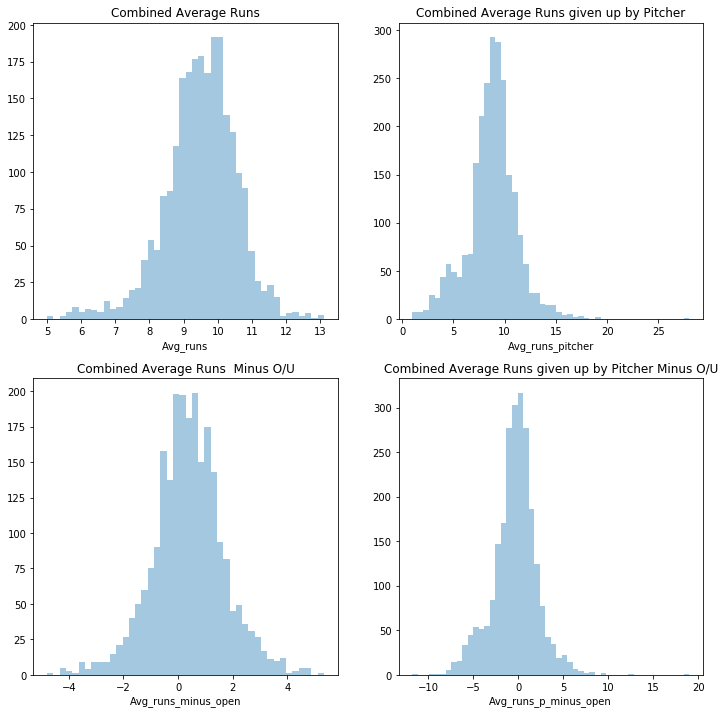

In [365]:
plt.figure(figsize=(12,12))

plt.subplot(2,2,1)
sns.distplot(games['Avg_runs'], kde=False)
plt.title('Combined Average Runs')

plt.subplot(2,2,2)
sns.distplot(games['Avg_runs_pitcher'], kde=False)
plt.title('Combined Average Runs given up by Pitcher')

plt.subplot(2,2,3)
sns.distplot(games['Avg_runs_minus_open'], kde=False)
plt.title('Combined Average Runs  Minus O/U')

plt.subplot(2,2,4)
sns.distplot(games['Avg_runs_p_minus_open'], kde=False)
plt.title('Combined Average Runs given up by Pitcher Minus O/U')
plt.show()

In [429]:
games['bin 1'] = (games['Avg_runs_minus_open'] // 1) + .5
games['bin 2'] = (games['Avg_runs_p_minus_open'] // 2)* 2 + 1


In [422]:
run_min_ou = games.groupby(['bin 1'])[['Over_open', 'Push_open', 'Under_open']].mean()
run_min_ou['ov_edge'] = run_min_ou['Over_open']/(run_min_ou['Under_open']+run_min_ou['Over_open'])
run_min_ou['un_edge'] = run_min_ou['Under_open']/(run_min_ou['Over_open']+run_min_ou['Under_open'])
#run_min_ou['bin 1'] = run_min_ou['bin 1'] + 0.5
run_min_ou


,Over_open,Push_open,Under_open,ov_edge,un_edge
bin 1,,,,,
-4.5,0.444444,0.111111,0.444444,0.500000,0.500000
-3.5,0.450000,0.050000,0.500000,0.473684,0.526316
-2.5,0.393443,0.081967,0.524590,0.428571,0.571429
-1.5,0.461165,0.058252,0.480583,0.489691,0.510309
-0.5,0.475548,0.045531,0.478921,0.498233,0.501767
0.5,0.466667,0.054088,0.479245,0.493351,0.506649
1.5,0.473029,0.045643,0.481328,0.495652,0.504348
2.5,0.555556,0.043210,0.401235,0.580645,0.419355
3.5,0.547170,0.075472,0.377358,0.591837,0.408163


In [423]:
games.groupby(['bin 1'])['Game ID'].count()

bin 1
-4.5      9
-3.5     20
-2.5     61
-1.5    206
-0.5    593
 0.5    795
 1.5    482
 2.5    162
 3.5     53
 4.5     13
 5.5      1
Name: Game ID, dtype: int64

In [431]:
prun_min_ou = games.groupby(['bin 2'])[['Over_open', 'Push_open', 'Under_open']].mean()
prun_min_ou['ov_edge'] = prun_min_ou['Over_open']/(prun_min_ou['Under_open']+prun_min_ou['Over_open'])
prun_min_ou['un_edge'] = prun_min_ou['Under_open']/(prun_min_ou['Over_open']+prun_min_ou['Under_open'])
#run_min_ou['bin 1'] = run_min_ou['bin 1'] + 0.5
prun_min_ou

,Over_open,Push_open,Under_open,ov_edge,un_edge
bin 2,,,,,
-11.0,1.000000,0.000000,0.000000,1.000000,0.000000
-9.0,1.000000,0.000000,0.000000,1.000000,0.000000
-7.0,0.476190,0.000000,0.523810,0.476190,0.523810
-5.0,0.487179,0.032051,0.480769,0.503311,0.496689
-3.0,0.465201,0.069597,0.465201,0.500000,0.500000
-1.0,0.455901,0.047205,0.496894,0.478488,0.521512
1.0,0.482500,0.055000,0.462500,0.510582,0.489418
3.0,0.548673,0.039823,0.411504,0.571429,0.428571
5.0,0.433333,0.066667,0.500000,0.464286,0.535714


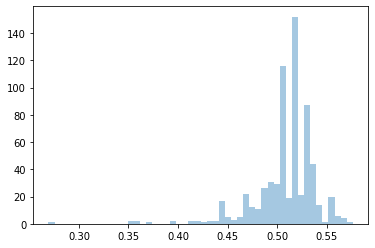

In [387]:
sns.distplot([x[0] for x in rfc.predict_proba(X_test)], kde=False)
plt.show()


In [427]:
y_test[([x[0] < .4 for x in rfc.predict_proba(X_test)])].mean()

0.5

11.799999999999997